In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
try:
    import empyrical as emp
except:
    emp = None
import tushare as ts
import time
import random
# from concurrent.futures import ProcessPoolExecutor

from common.log import *
from common.config import Config
from spider.spider_nasdaq import Spider_nasdaq
from spider.spider_coinmarketcap import Spider_coinmarketcap

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from pandas_highcharts.core import serialize
from pandas_highcharts.display import display_charts

from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:70% !important; }</style>"))

CONF = Config('../conf/secret.yaml').data[0]
ts_token = CONF['TUSHARE']['TOKEN']
ts.set_token(ts_token)
pro = ts.pro_api()

CONF = Config().data[0]
MONGODB = CONF['MONGODB']
NASDAQ = CONF['NASDAQ']
CRYPTOCURRENCY = CONF['CRYPTOCURRENCY']
CRYPTOCURRENCY = list(CRYPTOCURRENCY.keys())
NASDAQ100 = CONF['NASDAQ100']

TEST_LIST = ['399300']

pd

<module 'pandas' from 'd:\\python3\\lib\\site-packages\\pandas\\__init__.py'>

In [2]:
%%time

stock_df_dict = {}

for symbol in TEST_LIST:
    stock_data_file = '../database/market/%s.csv' % symbol
    try:
        stock_df = pd.read_csv(stock_data_file)
    except:
        print(symbol)
        continue

    # 筛选字段
#     stock_df = stock_df.loc[:, ['date', 'open', 'close']]
    
    # 特殊处理，用当天收盘价做判定和交易
#     stock_df['open'] = stock_df['close']

    # 去掉Nasdaq行情首行的当天行情
    if symbol in NASDAQ100:
        stock_df = stock_df.drop([0])

    # 抛弃空值异常值
    stock_df.dropna(axis=0, how='any', inplace=True)

    # 格式化日期
    # 445 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    stock_df = stock_df.assign(date=pd.to_datetime(stock_df['date']))  # need .index.to_period('D')

    # 用日期作索引，日期升序排序
    # 95.1 µs ± 1.58 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
    if symbol in NASDAQ100 or symbol in CRYPTOCURRENCY:
        stock_df = stock_df[::-1]
    stock_df.set_index(['date'], inplace=True)
    stock_df.index = stock_df.index.to_period('D')

    # 计算每天涨跌幅
#     stock_df['o_pct_chg'] = stock_df.open.pct_change(1)
#     stock_df['c_o_pct_chg'] = (stock_df.open - stock_df.close.shift(1)) / stock_df.close.shift(1)
#     stock_df['N_chg'] = stock_df.open.pct_change(N)
    # 用昨天收盘价做判定
#     stock_df['N_chg'] = (stock_df.close.shift(1) - stock_df.close.shift(N)) / stock_df.close.shift(N)
#     stock_df['N_sht'] = stock_df.open.shift(N)
#     stock_df['N_chn'] = stock_df.open.shift(N) - stock_df.open
#     stock_df['y_close'] = stock_df.close.shift(1)
    
    # MA均线指标
#     stock_df['MA%d' % M] = stock_df['open'].rolling(M).mean()
#     stock_df['MA%d' % M] = stock_df['close'].rolling(M).mean().shift(1)
    
    # 减少数据
    stock_df.dropna(how='any', inplace=True)
    
    stock_df_dict[symbol] = stock_df

Wall time: 32.9 ms


In [3]:
for symbol in TEST_LIST:
    symbol
    stock_df_dict[symbol].head(2)
    stock_df_dict[symbol].tail(2)

'399300'

,open,close,high,low,volume,code
date,,,,,,
2005-04-08,984.66,1003.45,1003.70,979.53,14762500.0,sz399300
2005-04-11,1003.88,995.42,1008.73,992.77,15936100.0,sz399300


,open,close,high,low,volume,code
date,,,,,,
2019-11-13,3905.28,3899.98,3908.42,3882.43,76749078.0,sz399300
2019-11-14,3905.93,3905.86,3916.95,3895.14,87008446.0,sz399300


In [4]:
'''
Select the number of periods (n) to include in the indicator. 
This should be based on the length of the cycle that you are analyzing. 
The most popular is 28 days (for intermediate cycles).
Determine the highest closing price (HCP) in n periods.
Determine the lowest closing price (LCP) in n periods.
Calculate the range of closing prices in n periods:
           HCP - LCP
Next, calculate the movement in closing price for each period:
           Closing price [today] - Closing price [yesterday]
Add up all price movements for n periods, disregarding whether they are up or down:
           Sum of absolute values of ( Close [today] - Close [yesterday] ) for n periods
Divide Step 4 by Step 6:
           VHF = (HCP - LCP) / (Sum of absolute values for n periods)
'''

'\nSelect the number of periods (n) to include in the indicator. \nThis should be based on the length of the cycle that you are analyzing. \nThe most popular is 28 days (for intermediate cycles).\nDetermine the highest closing price (HCP) in n periods.\nDetermine the lowest closing price (LCP) in n periods.\nCalculate the range of closing prices in n periods:\n           HCP - LCP\nNext, calculate the movement in closing price for each period:\n           Closing price [today] - Closing price [yesterday]\nAdd up all price movements for n periods, disregarding whether they are up or down:\n           Sum of absolute values of ( Close [today] - Close [yesterday] ) for n periods\nDivide Step 4 by Step 6:\n           VHF = (HCP - LCP) / (Sum of absolute values for n periods)\n'

In [5]:
df = stock_df_dict['399300'].copy()
N = 120
df['CLOSE_MA'] = df['close'].rolling(N).mean()
# df['close'] = df['CLOSE_MA']
df['HCP'] = df['close'].rolling(N).max()
df['LCP'] = df['close'].rolling(N).min()
df['DIFFCP'] = df['close'] - df['close'].shift()
df['DIFFCP'] = df['DIFFCP'].apply(abs)
df['SUMDIFFCP'] = df['DIFFCP'].rolling(N).sum()
df['VHF'] = (df['HCP'] - df['LCP']) / df['SUMDIFFCP']
df['VHF_MA'] = df['VHF'].rolling(N).mean()
df
o_df = df.copy()

,open,close,high,low,volume,code,CLOSE_MA,HCP,LCP,DIFFCP,SUMDIFFCP,VHF,VHF_MA
date,,,,,,,,,,,,,
2005-04-08,984.66,1003.45,1003.70,979.53,14762500.0,sz399300,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-04-11,1003.88,995.42,1008.73,992.77,15936100.0,sz399300,NaN,NaN,NaN,8.03,NaN,NaN,NaN
2005-04-12,993.71,978.70,993.71,978.20,10226200.0,sz399300,NaN,NaN,NaN,16.72,NaN,NaN,NaN
2005-04-13,987.95,1000.90,1006.50,987.95,16071700.0,sz399300,NaN,NaN,NaN,22.20,NaN,NaN,NaN
2005-04-14,1004.64,986.97,1006.42,985.58,12945700.0,sz399300,NaN,NaN,NaN,13.93,NaN,NaN,NaN
2005-04-15,982.61,974.08,982.61,971.93,10409000.0,sz399300,NaN,NaN,NaN,12.89,NaN,NaN,NaN
2005-04-18,970.91,963.77,970.91,958.65,8598400.0,sz399300,NaN,NaN,NaN,10.31,NaN,NaN,NaN
2005-04-19,962.92,965.89,968.87,957.91,9212620.0,sz399300,NaN,NaN,NaN,2.12,NaN,NaN,NaN
2005-04-20,964.15,950.87,964.15,946.20,8850700.0,sz399300,NaN,NaN,NaN,15.02,NaN,NaN,NaN


Index(['open', 'close', 'high', 'low', 'volume', 'code', 'CLOSE_MA', 'HCP',
       'LCP', 'DIFFCP', 'SUMDIFFCP', 'VHF', 'VHF_MA'],
      dtype='object')

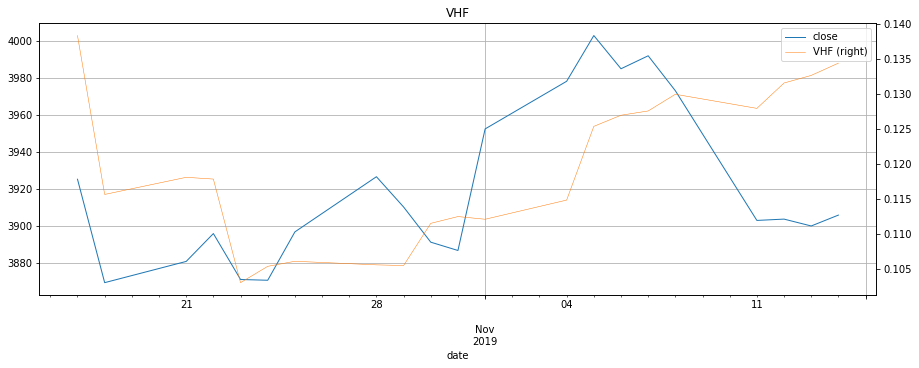

In [6]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]

df = o_df.copy()
df = df.iloc[3530:]
# df = o_df.loc[:, ['close', 'VHF_MA20']].copy()
# df.drop(columns=['PROPERTY'], inplace=True)
df.columns
df = df.dropna(how='any', inplace=False)

show_columns = ['close', 'VHF']
df = df.loc[:, show_columns]

# df['close'] = (df['close'] - df.iloc[0]['close']) / df.iloc[0]['close']
ax = df.plot(kind='line', y='close', title='VHF', linewidth=1, grid=True)
# ax = df.plot(kind='line', y='CLOSE_MA', secondary_y=False, title='VHF_N%d' % N, linewidth=1, grid=True)
ax = df.plot(kind='line', y='VHF', secondary_y=True, title='VHF', linewidth=0.5, grid=True, ax=ax)

In [7]:
df.reset_index(drop=False, inplace=True)
df['date'] = df['date'].apply(lambda x: x.to_timestamp().to_datetime64())
df.set_index(keys=['date'], inplace=True)

display_charts(df, secondary_y=['VHF'], chart_type='stock', kind='line', figsize=(900, 600), logy=False)